In [37]:

import torch
import torch.nn.functional as F

In [2]:
a = torch.randn(1, 129, 88)
input_size = a.shape[2]
input_size = 88
hidden_size = 400

rnn = torch.nn.RNN(input_size=input_size, hidden_size=hidden_size, bidirectional=True, batch_first=True)
out, hidden = rnn(a) # out: [1, 129, 800], hidden: [2, 1, 400]
print(f'out.shape: {out.shape}')
print(f'hidden.shape: {hidden.shape}')
h_left = out[:, :, :hidden_size]
h_right = out[:, :, hidden_size:]

print(f'h_left.shape: {h_left.shape}')
print(f'h_right.shape: {h_right.shape}')


out.shape: torch.Size([1, 129, 800])
hidden.shape: torch.Size([2, 1, 400])
h_left.shape: torch.Size([1, 129, 400])
h_right.shape: torch.Size([1, 129, 400])


In [3]:
z_0 = torch.randn(1, 1, 100)

In [4]:
combiner = torch.nn.Linear(100, 400)
h_combined = combiner(z_0)
h_combined = .5 * (F.tanh(h_combined) + h_right)
print(f'h_combined.shape: {h_combined.shape}')

h_combined.shape: torch.Size([1, 129, 400])


In [5]:
def softplus(x):
    return torch.log(1 + torch.exp(x))

In [6]:
mu_linear = torch.nn.Linear(400, 100)
sigma_linear = torch.nn.Linear(400, 100)

mu = mu_linear(h_combined)
sigma = softplus(sigma_linear(h_combined))

print(f'mu.shape: {mu.shape}')
print(f'sigma.shape: {sigma.shape}')    


mu.shape: torch.Size([1, 129, 100])
sigma.shape: torch.Size([1, 129, 100])


In [7]:
z_1 = mu + sigma * torch.randn_like(mu)


In [8]:
#emission function
emission = torch.nn.Sequential(
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 88),
    torch.nn.Sigmoid()
)

#transition function
G = torch.nn.Sequential(
    torch.nn.Linear(100, 200), #gating unit
    torch.nn.ReLU(),
    torch.nn.Linear(200, 100), #proposed mean
    torch.nn.Sigmoid()
)

H = torch.nn.Sequential(
    torch.nn.Linear(100, 200), #proposed mean
    torch.nn.ReLU(),
    torch.nn.Linear(200, 100), #proposed mean
    torch.nn.Identity(),
)

mu_gated_linear = torch.nn.Linear(100, 100) #w_{mu_p} * z_{t-1} + b_{mu_p}
sigma_gated_linear = torch.nn.Sequential( #w_{sigma_p} * relu(h_t) + b_{sigma_p}
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.Softplus(),
)
    




In [9]:
emission(z_1).shape

torch.Size([1, 129, 88])

In [10]:
#forward pass of transition function
z_0 = torch.zeros(1, 1, 100)
g_out = G(z_0)
one_minus_g = 1 - g_out # 1 - g
mu_linear_out = mu_gated_linear(z_0) #w_{mu_p} * z_{t-1} + b_{mu_p}
elementwise_mu_out = mu_linear_out * one_minus_g
proposed_mean_out = H(z_0)
mu_generator = (proposed_mean_out * g_out) + elementwise_mu_out

sigma_generator = sigma_gated_linear(proposed_mean_out)


print(f'out.shape: {one_minus_g.shape}')
print(f'sigma_generator.shape: {sigma_generator.shape}')

out.shape: torch.Size([1, 1, 100])
sigma_generator.shape: torch.Size([1, 1, 100])


In [11]:
z_1 = mu_generator + sigma_generator * torch.randn_like(mu_generator)

In [1]:
from model import DVAE

import torch
import torch.nn.functional as F

In [2]:
model = DVAE()

In [3]:
x = torch.randn(3, 129, 88)

In [4]:
x_hat, mus_p_z, sigmas_p_z, mus_generator, sigmas_generators = model(x)

In [5]:
def kl_normal(qm, qv, pm, pv):
    """
    Computes the elem-wise KL divergence between two normal distributions KL(q || p) and
    sum over the last dimension

    Args:
        qm: tensor: (batch, dim): q mean
        qv: tensor: (batch, dim): q variance
        pm: tensor: (batch, dim): p mean
        pv: tensor: (batch, dim): p variance

    Return:
        kl: tensor: (batch,): kl between each sample
    """
    
    element_wise = 0.5 * (torch.log(pv) - torch.log(qv) + qv / pv + (qm - pm).pow(2) / pv - 1)
    print(f'element_wise.shape: {element_wise.shape}')
    kl = element_wise.sum(-1)
    return kl

In [6]:
print(f'x_hat.shape: {x_hat.shape}')
print(f'mus_p_z.shape: {mus_p_z.shape}')
print(f'sigmas_p_z.shape: {sigmas_p_z.shape}')
print(f'mus_generator.shape: {mus_generator.shape}')
print(f'sigmas_generators.shape: {sigmas_generators.shape}')


x_hat.shape: torch.Size([3, 129, 88])
mus_p_z.shape: torch.Size([3, 129, 100])
sigmas_p_z.shape: torch.Size([3, 129, 100])
mus_generator.shape: torch.Size([3, 129, 100])
sigmas_generators.shape: torch.Size([3, 129, 100])


In [7]:
mu_z_1 = mus_p_z[:, 0, :]
sigma_z_1 = sigmas_p_z[:, 0, :]
print(f'mu_z_1.shape: {mu_z_1.shape}')
print(f'sigma_z_1.shape: {sigma_z_1.shape}')

mus_generator_1 = mus_generator[:, 0, :]
sigmas_generator_1 = sigmas_generators[:, 0, :]
print(f'mus_generator_1.shape: {mus_generator_1.shape}')
print(f'sigmas_generator_1.shape: {sigmas_generator_1.shape}')

single_kl = kl_normal(mu_z_1,
          sigma_z_1,
          mus_generator_1,
          sigmas_generator_1,
          )

print(f'single_kl: {single_kl}')

mu_z_1.shape: torch.Size([3, 100])
sigma_z_1.shape: torch.Size([3, 100])
mus_generator_1.shape: torch.Size([3, 100])
sigmas_generator_1.shape: torch.Size([3, 100])
element_wise.shape: torch.Size([3, 100])
single_kl: tensor([3.3950, 3.1909, 3.2479], grad_fn=<SumBackward1>)


In [10]:
from einops import rearrange, repeat

In [18]:
bce = torch.nn.BCEWithLogitsLoss(reduction='none')
def log_bernoulli_with_logits(x, logits, sequence_lengths):
    """
    Computes the log probability of a Bernoulli given its logits

    Args:
        x: tensor: (batch, dim): Observation
        logits: tensor: (batch, dim): Bernoulli logits

    Return:
        log_prob: tensor: (batch,): log probability of each sample
    """
    log_prob = F.binary_cross_entropy(input=logits, target=x) #-bce(input=logits, target=x) #TODO: check if suming over t is correct
    bs, max_sequence_length, _ = x.shape
    
    range_tensor = repeat(torch.arange(max_sequence_length), 'l -> b l', b=bs).to(x.device)
    mask = range_tensor < rearrange(sequence_lengths, 'b -> b ()')
    mask = rearrange(mask, 'b s -> b s ()')

    nll = log_prob * mask.float()
    
    return nll.sum(-1).sum(-1)

In [9]:
recon_loss = -log_bernoulli_with_logits(x_hat, x)

In [10]:
#KL(q, p) for t=2 to T

kl_q_p_2 = kl_normal(mus_generator[:, 1:, :],
          sigmas_generators[:, 1:, :],
          mus_p_z[:, 1:, :],
          sigmas_p_z[:, 1:, :])

element_wise.shape: torch.Size([3, 128, 100])


In [11]:
kl_q_p_2.sum(-1).shape

torch.Size([3])

In [12]:
single_kl

tensor([3.3950, 3.1909, 3.2479], grad_fn=<SumBackward1>)

In [13]:
nelbo_loss = recon_loss.mean() + kl_q_p_2.sum(-1).mean() + single_kl.mean()

In [19]:
from omegaconf import OmegaConf
import argparse
import os
import torch
from omegaconf import OmegaConf
from torch.utils.data import DataLoader
import wandb

from dataloader import MusicDataset
from model import DVAE 

In [20]:
path = 'config.yaml'

config = OmegaConf.load(path)

In [21]:


dataset = MusicDataset(config.dataset)
dataloader = DataLoader(dataset, 
                        batch_size=config.train.batch_size, 
                        num_workers=config.train.num_workers,
                        pin_memory=True, #important for speed
                        shuffle=True)

device = torch.device('mps')
model = DVAE(input_dim=config.model.input_dim, 
                hidden_dim=config.model.hidden_dim,
                hidden_dim_em=config.model.hidden_dim_em, 
                hidden_dim_tr=config.model.hidden_dim_tr, 
                latent_dim=config.model.latent_dim)
model = model.to(device)

    
for i, (encodings, sequence_lengths) in enumerate(dataloader):
    # print(f'encodings.shape: {encodings.shape}'
    #       f'masks.shape: {masks.shape}'
    #       f'sequence_lengths.shape: {sequence_lengths.shape}')
    encodings = encodings.to(device)
    # masks = masks.to(device)
#     sequence_lengths = sequence_lengths.to(device)
    x_hat, mus_inference, sigmas_inference, mus_generator, sigmas_generators = model(encodings)
    
    

In [22]:
print(f'x_hat.shape: {x_hat.shape}')
print(f'mus_p_z.shape: {mus_inference.shape}')
print(f'sigmas_p_z.shape: {sigmas_inference.shape}')
print(f'mus_generator.shape: {mus_generator.shape}')
print(f'sigmas_generators.shape: {sigmas_generators.shape}')


x_hat.shape: torch.Size([37, 129, 88])
mus_p_z.shape: torch.Size([37, 129, 100])
sigmas_p_z.shape: torch.Size([37, 129, 100])
mus_generator.shape: torch.Size([37, 129, 100])
sigmas_generators.shape: torch.Size([37, 129, 100])


In [26]:
x_hat

tensor([[[0.4859, 0.5299, 0.5224,  ..., 0.5078, 0.5089, 0.5274],
         [0.4966, 0.5218, 0.5254,  ..., 0.5173, 0.5178, 0.5077],
         [0.4905, 0.5380, 0.5138,  ..., 0.5170, 0.5183, 0.5388],
         ...,
         [0.4780, 0.5150, 0.5275,  ..., 0.5088, 0.5482, 0.4937],
         [0.5051, 0.5314, 0.5361,  ..., 0.4933, 0.4987, 0.5184],
         [0.4979, 0.5187, 0.5203,  ..., 0.5258, 0.4945, 0.5186]],

        [[0.4718, 0.5219, 0.5250,  ..., 0.4888, 0.5122, 0.4924],
         [0.5032, 0.5299, 0.5289,  ..., 0.5124, 0.5183, 0.4993],
         [0.4930, 0.5425, 0.5235,  ..., 0.4983, 0.5220, 0.5124],
         ...,
         [0.4972, 0.5407, 0.4976,  ..., 0.5171, 0.5144, 0.5400],
         [0.5184, 0.5251, 0.5346,  ..., 0.5290, 0.5155, 0.5194],
         [0.5043, 0.5218, 0.5230,  ..., 0.5319, 0.5118, 0.4994]],

        [[0.4900, 0.5395, 0.5174,  ..., 0.5028, 0.5152, 0.5365],
         [0.5120, 0.5314, 0.5197,  ..., 0.5135, 0.4993, 0.5329],
         [0.4960, 0.5352, 0.5275,  ..., 0.5298, 0.4976, 0.

In [27]:
nll = log_bernoulli_with_logits(x_hat, encodings, sequence_lengths.to(device))
nll.shape
nll

tensor([-3995.2393, -2767.0425, -5903.4951, -4180.5957, -2519.7283, -3935.4448,
        -2766.2849, -5224.0972, -3751.3345, -3997.0784, -2028.6697, -3258.9133,
        -3503.3894, -3932.9912, -3996.2595, -3994.0000, -2765.6836, -3935.3130,
        -3996.2842, -3505.1663, -3012.1821, -2274.0977, -2950.3484, -3994.8369,
        -3012.2085, -3013.1709, -3504.4243, -4241.6216, -3996.7361, -4240.3374,
        -3012.4373, -2950.4971, -2458.5959, -5715.3682, -5473.3911, -4179.5400,
        -3997.2388], device='mps:0', grad_fn=<SumBackward1>)

In [ ]:
nll.mean().backward()

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [MPSFloatType [37, 100]], which is output 0 of AsStridedBackward0, is at version 129; expected version 128 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

In [102]:
from einops import repeat, rearrange
"""
Computes the elem-wise KL divergence between two normal distributions KL(q || p) and
sum over the last dimension

Args:
    qm: tensor: (batch, dim): q mean
    qv: tensor: (batch, dim): q variance
    pm: tensor: (batch, dim): p mean
    pv: tensor: (batch, dim): p variance

Return:
    kl: tensor: (batch,): kl between each sample
"""
qm = mus_generator
qv = sigmas_generators
pm = mus_inference
pv = sigmas_inference

element_wise = 0.5 * (torch.log(pv) - torch.log(qv) + qv / pv + (qm - pm).pow(2) / pv - 1)

# mask out the padding after sequence length for each datapoint
bs, max_sequence_length, _ = element_wise.shape

# range_tensor = torch.arange(max_sequence_length).unsqueeze(0).expand(bs, -1) # [seq] -> [1, seq] -> [bs, seq]
range_tensor = repeat(torch.arange(max_sequence_length), 'l -> b l', b=bs)
mask = range_tensor < rearrange(sequence_lengths, 'b -> b ()')
mask = rearrange(mask, 'b s -> b s ()')

kl = element_wise * mask.float()
kl = kl.sum(-1).sum(-1)


In [109]:
kl.mean().backward()

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [85]:
range_tensor = torch.arange(129).unsqueeze(0).expand(element_wise.shape[0], -1).to('cpu')

# Create the mask: True for elements we want to keep, False for elements to be masked
mask = range_tensor < sequence_lengths.unsqueeze(1).to('cpu')

# Apply the mask to the data
# You need to unsqueeze the mask to make its shape (batch_size, sequence_length, 1) so it broadcasts correctly over the feature dimension
masked_data = element_wise * mask.unsqueeze(2).float()

In [86]:
element_wise.sum(-1).sum(-1)

tensor([703.9436, 710.7096, 704.5284, 673.8802, 701.5371, 705.6766, 693.5052,
        696.0417, 708.2553, 719.8946, 676.9679, 706.6138, 710.3296, 703.0452,
        697.2532, 714.9741, 686.5779, 712.7692, 731.7780, 722.0126, 721.5752,
        678.3644, 711.3787, 705.0903, 693.5876, 665.4576, 686.4227, 665.4719,
        704.4774, 688.3771, 707.5785, 695.1637, 714.8768, 700.8198, 694.5972,
        691.2836, 700.0506], grad_fn=<SumBackward1>)

In [87]:
masked_data.sum(-1).sum(-1).shape

torch.Size([37])

In [88]:
torch.arange(129).unsqueeze(0).expand(element_wise.shape[0], 0).shape

RuntimeError: The expanded size of the tensor (0) must match the existing size (129) at non-singleton dimension 1.  Target sizes: [37, 0].  Tensor sizes: [1, 129]

In [91]:
masked_data.mean()

tensor(0.0254, grad_fn=<MeanBackward0>)

In [313]:
from midiutil import MIDIFile
from pydub import AudioSegment
from midi2audio import FluidSynth

In [350]:
config = OmegaConf.load('config.yaml')
model = DVAE(input_dim=config.model.input_dim, 
                    hidden_dim=config.model.hidden_dim,
                    hidden_dim_em=config.model.hidden_dim_em, 
                    hidden_dim_tr=config.model.hidden_dim_tr, 
                    latent_dim=config.model.latent_dim).to('mps')
    
#load weights
ckpt_path = 'saved_models/dvae_model_100.pt'
ckpt = torch.load(ckpt_path, map_location='mps')
model.load_state_dict(ckpt)


<All keys matched successfully>

In [351]:
z = torch.randn(1, 40, 100).to('mps')

In [371]:
with torch.no_grad():
    x_hat, mu, sigma = model.decoder(z)
    x_hat = x_hat.squeeze(0).cpu().numpy()

In [376]:
sigma[:, :, 5]

tensor([[0.6798, 0.6783, 0.6807, 0.6826, 0.6846, 0.6859, 0.6824, 0.6810, 0.6870,
         0.6824, 0.6863, 0.6831, 0.6825, 0.6837, 0.6790, 0.6841, 0.6850, 0.6838,
         0.6834, 0.6869, 0.6816, 0.6865, 0.6848, 0.6861, 0.6832, 0.6848, 0.6841,
         0.6841, 0.6849, 0.6882, 0.6837, 0.6846, 0.6873, 0.6832, 0.6845, 0.6810,
         0.6855, 0.6856, 0.6818, 0.6818]], device='mps:0')

In [369]:
x_hat.shape

(40, 88)

Text(0, 0.5, 'time step')

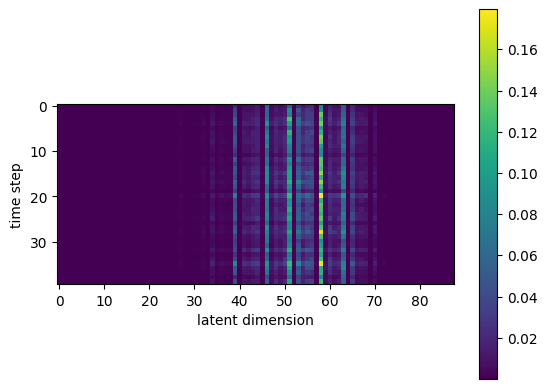

In [372]:
plt.imshow(x_hat)
plt.colorbar()
#x axis title
plt.xlabel('latent dimension')
#y axis title

plt.ylabel('time step')

Text(0, 0.5, 'time step')

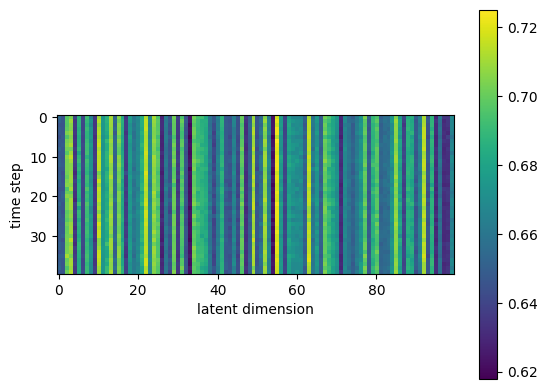

In [363]:
plt.imshow(sigma.squeeze(0).cpu().numpy())
plt.colorbar()
#x axis title
plt.xlabel('latent dimension')
#y axis title

plt.ylabel('time step')

Text(0, 0.5, 'time step')

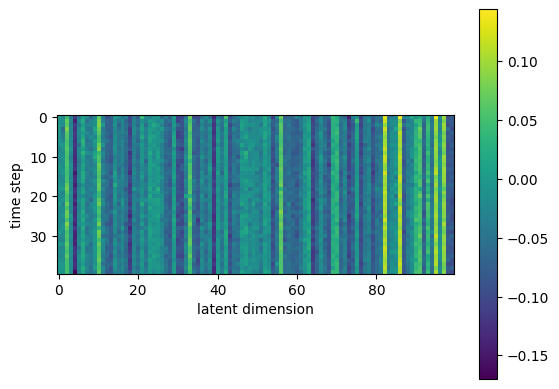

In [377]:
plt.imshow(mu.squeeze(0).cpu().numpy())
plt.colorbar()
#x axis title
plt.xlabel('latent dimension')
#y axis title

plt.ylabel('time step')

In [353]:
np.where(x_hat > 0.13)

(array([ 5,  7, 15, 15, 17, 18, 22, 23, 23, 26, 26, 27, 28, 31, 34, 37, 37,
        39]),
 array([58, 58, 51, 58, 58, 58, 58, 51, 58, 46, 58, 58, 58, 58, 58, 51, 58,
        58]))

In [354]:
z = torch.randn(1, 40, 100).to('mps')
with torch.no_grad():
    x_hat, _, _ = model.decoder(z)
    x_hat = x_hat.squeeze(0).cpu().numpy()

x_hat[np.where(x_hat > .05)] = 1 
x_hat[np.where(x_hat <= .05)] = 0
# print(np.where(x_hat == 1))

# print( np.unique(x_hat) )
x_hat[np.where(x_hat == 1)] = np.where(x_hat == 1)[1] + 21
#convert to float
x_hat = x_hat.astype(int)
# print(np.where(x_hat == 1))
# plt.imshow(x_hat)
#only get non_zero values in the sequence while preserving the shape of [10, x] where x are the remianing values
midis = []

for i in range(x_hat.shape[0]):
    non_zero = np.nonzero(x_hat[i])
    midis.append( tuple(x_hat[i][non_zero]) )
    

In [355]:
import pickle
import torch
import numpy as np

In [356]:
fs = FluidSynth('default.sf2')

In [347]:


data = midis
# Create a MIDI file
midi_file = MIDIFile(1)  # One track
track = 0
time = 0  # Start at the beginning
midi_file.addTrackName(track, time, "Track")
midi_file.addTempo(track, time, 120)  # Set the tempo

# Add notes to the MIDI file
for chord in data:  # Assuming you're using the first song
    duration = 1  # Duration of each chord, you can change this
    for note in chord:
        midi_file.addNote(track, 0, note, time, duration, 100)  # channel set to 0, volume 100
    time += duration

# Write the MIDI file to disk
with open("output.mid", "wb") as output_file:
    midi_file.writeFile(output_file)

# Synthesize MIDI to WAV using FluidSynth
# fs = FluidSynth('path_to_soundfont.sf2')
fs.midi_to_audio('output.mid', 'output.wav')

# Convert WAV to MP3
audio = AudioSegment.from_wav('output.wav')
audio.export('output.mp3', format='mp3')

FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'output.wav'..


<_io.BufferedRandom name='output.mp3'>

In [348]:
def midi_to_song(data):
    # Create a MIDI file
    midi_file = MIDIFile(1)  # One track
    track = 0
    time = 0  # Start at the beginning
    midi_file.addTrackName(track, time, "Track")
    midi_file.addTempo(track, time, 120)  # Set the tempo

    # Add notes to the MIDI file
    for chord in data:  # Assuming you're using the first song
        duration = 1  # Duration of each chord, you can change this
        for note in chord:
            midi_file.addNote(track, 0, note, time, duration, 100)  # channel set to 0, volume 100
        time += duration

    # Write the MIDI file to disk
    with open("output.mid", "wb") as output_file:
        midi_file.writeFile(output_file)

    # Synthesize MIDI to WAV using FluidSynth
    # fs = FluidSynth('path_to_soundfont.sf2')
    fs.midi_to_audio('output.mid', 'output.wav')

    # Convert WAV to MP3
    audio = AudioSegment.from_wav('output.wav')
    audio.export('output.mp3', format='mp3')
    

In [349]:
path = 'data/jsb_chorales.pickle'

In [287]:
with open(path, 'rb') as file:
    data = pickle.load(file)

In [288]:
asong = data['train'][1]

In [312]:
asong

[(73, 77, 80, 85),
 (70, 77, 82, 85),
 (65, 80, 83, 85),
 (66, 78, 82, 85),
 (67, 75, 82, 87),
 (68, 75, 82, 83),
 (63, 73, 82),
 (56, 73, 80),
 (60, 75, 80, 87),
 (61, 73, 80, 89),
 (63, 70, 79, 87),
 (65, 68, 80, 85),
 (67, 75, 84),
 (68, 75, 84),
 (63, 73, 75, 82),
 (56, 72, 75, 80),
 (65, 73, 80, 85),
 (64, 73, 82, 85),
 (61, 77, 80, 85),
 (66, 78, 82, 85),
 (67, 75, 82, 87),
 (68, 75, 82, 83),
 (63, 73, 82),
 (56, 72, 80),
 (60, 75, 80, 87),
 (61, 73, 80, 89),
 (63, 70, 79, 87),
 (65, 68, 80, 85),
 (67, 75, 84),
 (68, 75, 84),
 (63, 73, 75, 82),
 (56, 72, 75, 80),
 (65, 77, 85, 92),
 (70, 73, 82, 90),
 (73, 77, 80, 89),
 (66, 80, 84, 87),
 (65, 80, 85),
 (66, 73, 82, 85),
 (61, 73, 80, 89),
 (68, 72, 80, 87),
 (65, 74, 80, 89),
 (63, 75, 78, 90),
 (68, 75, 83, 89),
 (71, 75, 82, 87),
 (70, 77, 82, 86),
 (63, 78, 82, 87),
 (63, 78, 82, 87),
 (63, 78, 82, 87),
 (66, 72, 75, 80),
 (65, 73, 80, 85),
 (63, 66, 82, 87),
 (61, 68, 85, 89),
 (63, 78, 84, 90),
 (65, 78, 80, 92),
 (66, 75, 

In [289]:
midi_to_song(asong)

FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'output.wav'..


In [290]:
all_music_one_hot_list = []    
sequence_lengths = []

one_hot_matrix = np.zeros((len(asong), 88), dtype=int)
            
for row_index, keys in enumerate(asong):

    for note in keys:
        one_hot_matrix[row_index, note - 21] = 1  
        
all_music_one_hot_list.append(one_hot_matrix)
sequence_lengths.append(len(asong))

In [309]:
song = torch.tensor(all_music_one_hot_list).to(dtype=torch.float32).to('mps')
x_hat, _, _, _, _ = model(song)
with torch.no_grad():
    # x_hat, _, _ = model.decoder(z)
    x_hat = x_hat.squeeze(0).cpu().numpy()

x_hat[np.where(x_hat > .1)] = 1 
x_hat[np.where(x_hat <= .1)] = 0

x_hat[np.where(x_hat == 1)] = np.where(x_hat == 1)[1]
#convert to float
x_hat = x_hat.astype(int)
#only get non_zero values in the sequence while preserving the shape of [10, x] where x are the remianing values
midis = []

for i in range(x_hat.shape[0]):
    non_zero = np.nonzero(x_hat[i])
    midis.append( tuple(x_hat[i][non_zero]) )
    

In [310]:
midis

[(51, 58),
 (39, 46, 51, 53, 55, 58, 63),
 (46, 51, 53, 58, 63),
 (46, 51, 58, 63),
 (46, 51, 58, 63),
 (39, 46, 51, 53, 55, 58, 63),
 (46, 51, 53, 58, 63),
 (46, 51, 58, 63),
 (46, 51, 58, 63),
 (46, 51, 53, 58, 63),
 (46, 51, 58, 63),
 (46, 51, 58, 63),
 (46, 51, 53, 58, 63),
 (46, 51, 58, 63),
 (46, 51, 58, 63),
 (39, 46, 51, 58, 63),
 (46, 51, 58, 63),
 (39, 46, 51, 53, 55, 58, 63),
 (46, 51, 58, 63),
 (51, 58),
 (39, 46, 51, 53, 55, 58, 63),
 (46, 51, 53, 58, 63),
 (46, 51, 53, 58, 63),
 (51, 58, 63),
 (46, 51, 53, 58, 63),
 (46, 51, 53, 55, 58, 63),
 (46, 51, 58, 63),
 (46, 51, 58, 63),
 (46, 51, 53, 58, 63),
 (46, 51, 53, 58, 63),
 (51, 58, 63),
 (46, 51, 58, 63),
 (46, 51, 58, 63),
 (46, 51, 53, 58, 63),
 (51, 58, 63),
 (46, 51, 58, 63),
 (46, 51, 53, 58, 63),
 (46, 51, 53, 58, 63),
 (46, 51, 58, 63),
 (46, 51, 58, 63),
 (46, 51, 58, 63),
 (46, 51, 58, 63),
 (46, 51, 58, 63),
 (39, 46, 51, 53, 55, 58, 63),
 (51, 58),
 (46, 51, 55, 56, 58, 63),
 (39, 46, 51, 53, 55, 58, 63),
 (3

In [311]:
midi_to_song(midis)

FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'output.wav'..
